In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import keras
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (16, 8)})

In [ ]:
# ==============================================================
# 0.  Sentiment‑plus‑price feature engineering  (run before LSTM)
# ==============================================================

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt   # Optional, only if you want the preview plots

# ---------- Load daily sentiment scores ----------
sentiment_df = pd.read_csv("daily_sentiment_df_nvidia.csv")
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"])
sentiment_df.set_index("date", inplace=True)

# 7‑day moving‑average sentiment (smoother signal)
sentiment_df["MA7"] = sentiment_df["NormSentiment"].rolling(window=5).mean()

# ---------- Download GOOGL daily closes (2‑month buffer) ----------
googl_df = yf.download("NVDA",
                       start="2020-04-01",
                       end="2023-06-30")[["Close", "Volume"]].rename(columns={"Close": "StockPrice"})
if isinstance(googl_df.columns, pd.MultiIndex):
  googl_df.columns = [col[0] for col in googl_df.columns]

# ---------- Detrend using raw (non-normalized) stock price ----------
googl_df["Price_MA30_raw"]     = googl_df["StockPrice"].rolling(30).mean()
googl_df["DetrendedPrice_raw"] = googl_df["StockPrice"] - googl_df["Price_MA30_raw"]

# ---------- Min‑max normalize price after detrending ----------
googl_df["NormPrice"] = (
    googl_df["StockPrice"] - googl_df["StockPrice"].min()
) / (googl_df["StockPrice"].max() - googl_df["StockPrice"].min())

googl_df["Price_MA30"]     = googl_df["NormPrice"].rolling(30).mean()
googl_df["DetrendedPrice"] = googl_df["NormPrice"] - googl_df["Price_MA30"]

# ---------- Merge price + sentiment ----------
combined = googl_df.join(sentiment_df[["NormSentiment", "MA7"]], how="inner")

# ---------- Scale to comparable ranges ----------
combined["DetrendedPrice_scaled"] = combined["DetrendedPrice"] / combined["DetrendedPrice"].abs().max()

max_sent_abs = max(combined["NormSentiment"].abs().max(), combined["MA7"].abs().max())
combined["NormSentiment_scaled"] = combined["NormSentiment"] / max_sent_abs
combined["MA7_scaled"]           = combined["MA7"]           / max_sent_abs

# ---------- Optional lead/lag test (use if you want shifted features) ----------
shift_days = 3
combined["NormSentiment_scaled_shifted"] = combined["NormSentiment_scaled"].shift(-shift_days)
combined["MA7_scaled_shifted"]           = combined["MA7_scaled"].shift( shift_days)

# ---------- Restrict to training window & drop NaNs ----------
combined = combined.loc["2021-11-01":"2022-12-31"]
combined.dropna(subset=["DetrendedPrice_scaled", "MA7_scaled"], inplace=True)

# ---------- Expose final DataFrame for LSTM ----------
joined_df = combined.copy()   # <- the LSTM cell starts with joined_df.copy()
combined_df = joined_df.copy()
print("Joined feature set ready – shape:", joined_df.shape)
joined_df

[*********************100%***********************]  1 of 1 completed

Joined feature set ready – shape: (294, 14)


,StockPrice,Volume,Price_MA30_raw,DetrendedPrice_raw,NormPrice,Price_MA30,DetrendedPrice,NormSentiment,MA7,DetrendedPrice_scaled,NormSentiment_scaled,MA7_scaled,NormSentiment_scaled_shifted,MA7_scaled_shifted
2021-11-01,25.778589,265740000,22.008270,3.770319,0.522776,0.422846,0.099930,0.191464,0.193985,0.361745,0.326130,0.330424,0.398106,0.064326
2021-11-02,26.351511,294112000,22.179781,4.171730,0.537961,0.427392,0.110569,0.133405,0.202444,0.400258,0.227236,0.344834,0.458027,0.073643
2021-11-03,26.548141,239910000,22.334724,4.213418,0.543172,0.431498,0.111674,0.199311,0.207363,0.404258,0.339497,0.353212,0.232567,0.235967
2021-11-04,29.745142,1153631000,22.578233,7.166909,0.627907,0.437952,0.189954,0.233719,0.163000,0.687632,0.398106,0.277647,0.055183,0.330424
2021-11-05,29.696232,851260000,22.833454,6.862778,0.626610,0.444717,0.181893,0.268897,0.205359,0.658452,0.458027,0.349799,0.229338,0.344834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,15.193551,349326000,16.381741,-1.188190,0.242226,0.273718,-0.031492,0.105783,0.076117,-0.114001,0.180185,0.129654,0.096040,0.015068
2022-12-27,14.109439,464902000,16.308407,-2.198968,0.213492,0.271775,-0.058282,0.028027,0.030327,-0.210981,0.047739,0.051657,0.063310,0.028721
2022-12-28,14.024508,351066000,16.233307,-2.208799,0.211241,0.269784,-0.058543,0.046017,0.018374,-0.211924,0.078383,0.031297,0.186089,0.062890
2022-12-29,14.591045,354923000,16.164739,-1.573693,0.226257,0.267967,-0.041710,0.056383,0.028387,-0.150989,0.096040,0.048352,0.143589,0.129654


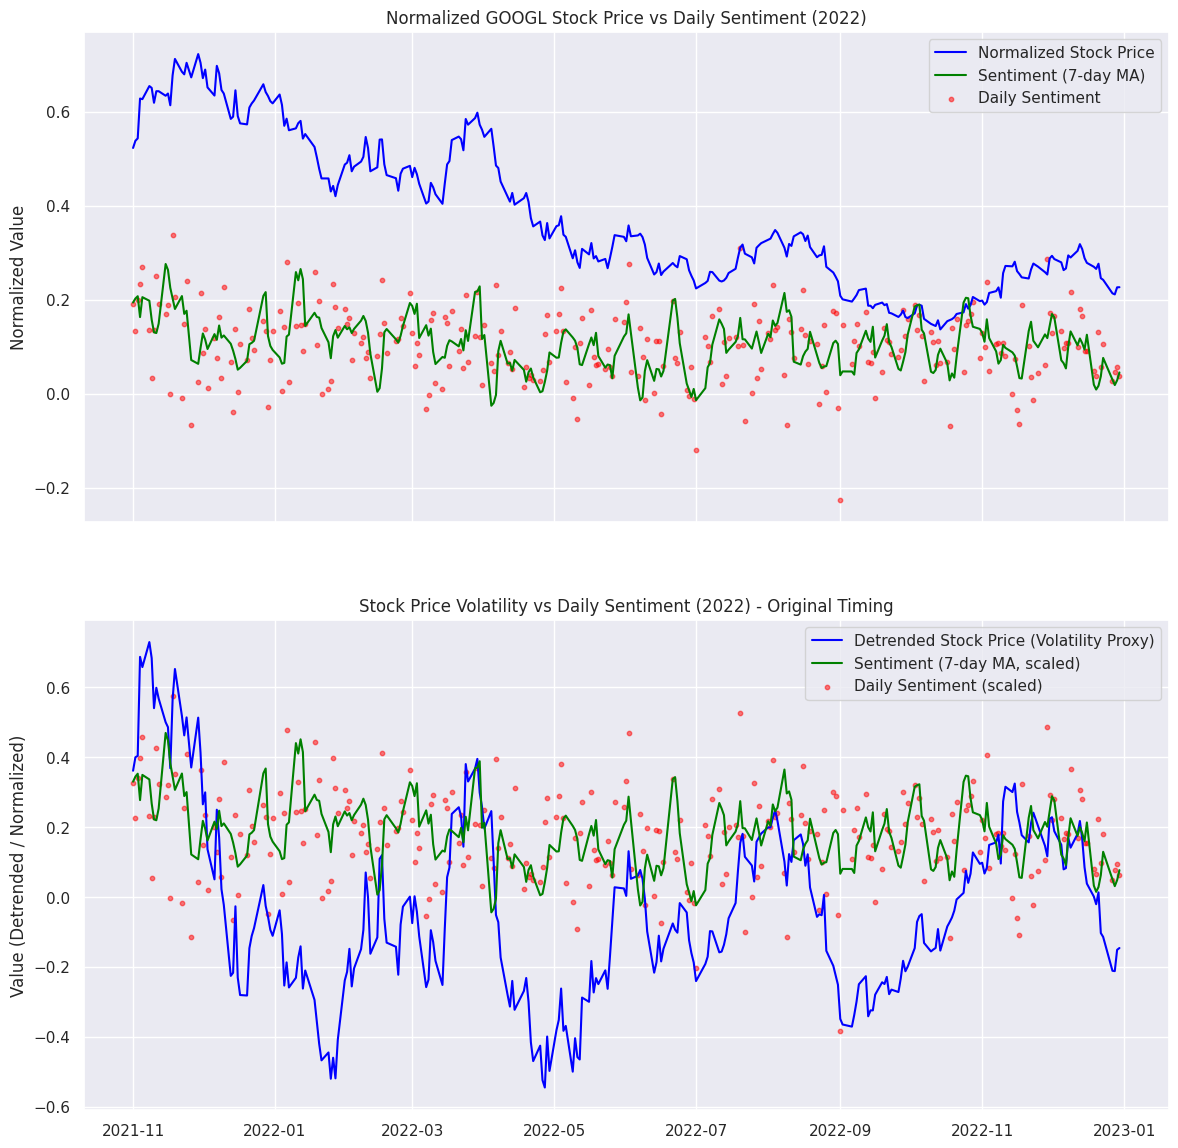

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14, 14), sharex=True)

# 1) Normalized stock price vs Sentiment (original scales)
axs[0].plot(combined_df.index, combined_df["NormPrice"], label="Normalized Stock Price", color='blue')
axs[0].plot(combined_df.index, combined_df["MA7"], label="Sentiment (7-day MA)", color='green')
axs[0].scatter(combined_df.index, combined_df["NormSentiment"], label="Daily Sentiment", color='red', s=10, alpha=0.5)
axs[0].set_title("Normalized GOOGL Stock Price vs Daily Sentiment (2022)")
axs[0].set_ylabel("Normalized Value")
axs[0].legend()
axs[0].grid(True)

# 2) Detrended price vs Sentiment (original timing)
axs[1].plot(combined_df.index, combined_df["DetrendedPrice_scaled"], label="Detrended Stock Price (Volatility Proxy)", color='blue')
axs[1].plot(combined_df.index, combined_df["MA7_scaled"], label="Sentiment (7-day MA, scaled)", color='green')
axs[1].scatter(combined_df.index, combined_df["NormSentiment_scaled"], label="Daily Sentiment (scaled)", color='red', s=10, alpha=0.5)
axs[1].set_title("Stock Price Volatility vs Daily Sentiment (2022) - Original Timing")
axs[1].set_ylabel("Value (Detrended / Normalized)")
axs[1].legend()
axs[1].grid(True)

Epoch 1/200
12/12 - 15s - 1s/step - loss: 0.1990 - val_loss: 0.1032 - learning_rate: 1.0000e-03
Epoch 2/200
12/12 - 5s - 400ms/step - loss: 0.1189 - val_loss: 0.0486 - learning_rate: 1.0000e-03
Epoch 3/200
12/12 - 0s - 13ms/step - loss: 0.1066 - val_loss: 0.0542 - learning_rate: 1.0000e-03
Epoch 4/200
12/12 - 0s - 12ms/step - loss: 0.1005 - val_loss: 0.0391 - learning_rate: 1.0000e-03
Epoch 5/200
12/12 - 0s - 13ms/step - loss: 0.0860 - val_loss: 0.0324 - learning_rate: 1.0000e-03
Epoch 6/200
12/12 - 0s - 12ms/step - loss: 0.0879 - val_loss: 0.0317 - learning_rate: 1.0000e-03
Epoch 7/200
12/12 - 0s - 13ms/step - loss: 0.0794 - val_loss: 0.0315 - learning_rate: 1.0000e-03
Epoch 8/200
12/12 - 0s - 12ms/step - loss: 0.0752 - val_loss: 0.0357 - learning_rate: 1.0000e-03
Epoch 9/200
12/12 - 0s - 12ms/step - loss: 0.0861 - val_loss: 0.0365 - learning_rate: 1.0000e-03
Epoch 10/200
12/12 - 0s - 12ms/step - loss: 0.0713 - val_loss: 0.0299 - learning_rate: 1.0000e-03
Epoch 11/200
12/12 - 0s - 12m

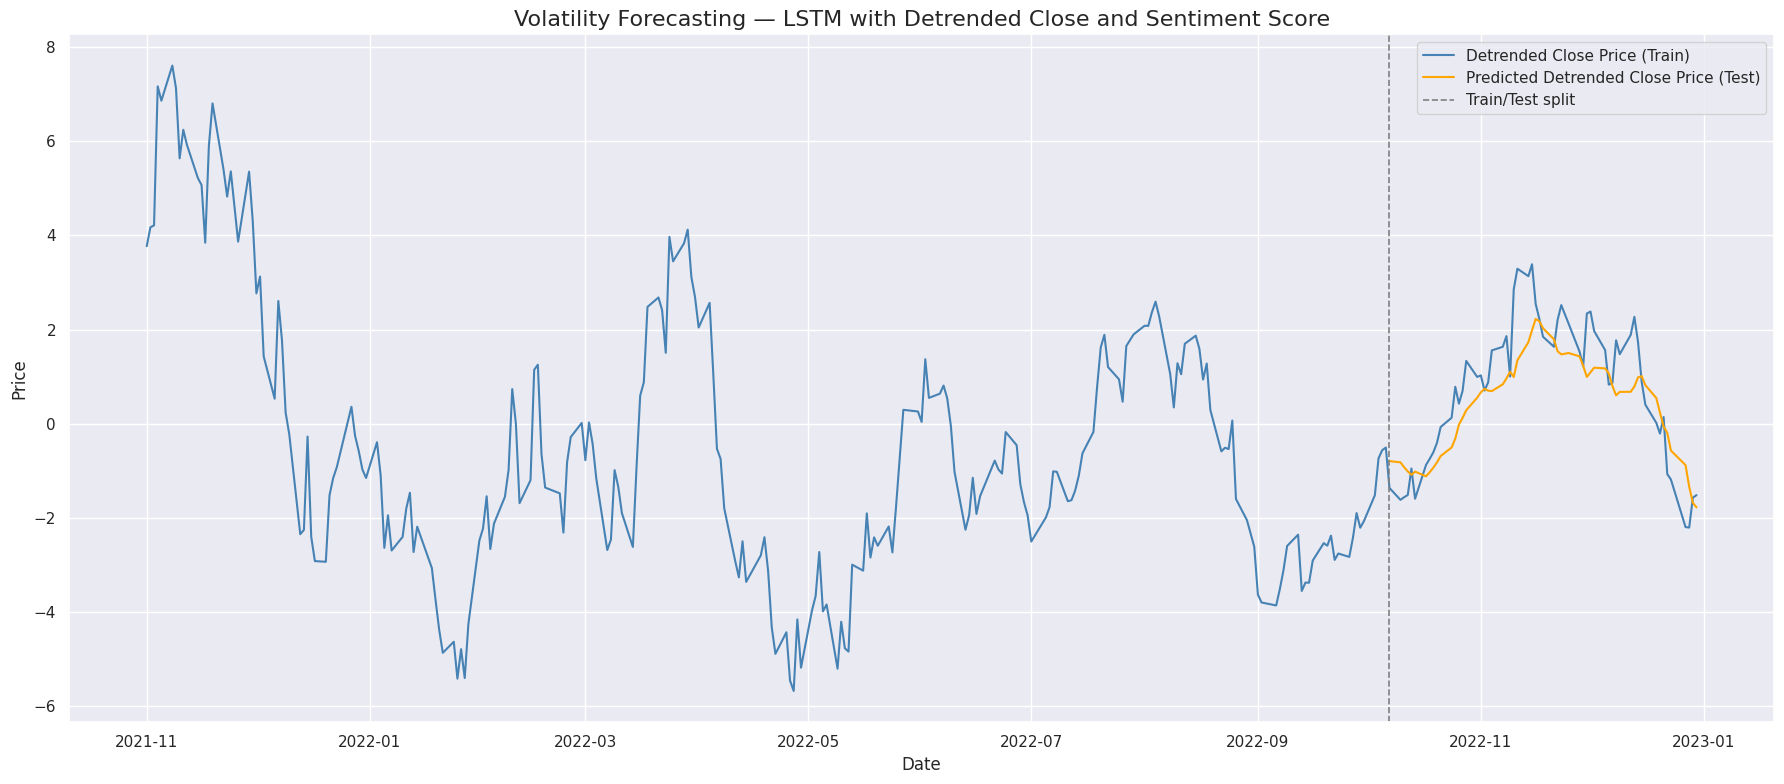

In [ ]:
# ==============================================================
# 0.  Imports (if not already)
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Attention, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# ==============================================================
# 1.  Feature engineering
# ==============================================================

df = joined_df.copy()

# --- return & volatility --------------------------------------
# df["Return_1d"] = df["Close"].pct_change()
# df["Vol_20d"]   = df["Return_1d"].rolling(20).std()

# --- news features should already exist -----------------------
# df["positive_score"], df["negative_score"]

# drop rows with new NaNs (first pct_change, first 20 rows of rolling)
df = df.dropna(subset=['DetrendedPrice',   'MA7'])

# ==============================================================
# 2.  Choose feature set  (now 6 columns)
# ==============================================================

features = [
    'DetrendedPrice_raw',
]
data = df[features]

# ==============================================================
# 3.  Scale, split, sequences
# ==============================================================

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

train_size = int(0.8 * len(data))
train, test = scaled[:train_size], scaled[train_size:]

window = 30
if len(test) <= window:
    raise ValueError("Test set too small. Reduce window or use larger test split.")
def create_sequences(arr, seq_len=window):
    X, y = [], []
    for i in range(seq_len, len(arr)):
        X.append(arr[i-seq_len:i])
        y.append(arr[i, 0])         # index 0 = scaled Close
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train)
# Concatenate the last `window` points of training with test to ensure full context
test_input = np.concatenate([train[-window:], test], axis=0)
X_test, y_test = create_sequences(test_input)


# ==============================================================
# 4.  Build model  (same architecture)
# ==============================================================

K.clear_session()
seq_len, n_feat = X_train.shape[1], X_train.shape[2]   # n_feat = 6

model = Sequential([
    Bidirectional(LSTM(32, return_sequences=True, activation='tanh'),
                  input_shape=(seq_len, n_feat)),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')

early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
rlr   = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early, rlr],
    verbose=2
)

# ==============================================================
# 5.  Predict & inverse‑scale
# ==============================================================
pred_scaled = model.predict(X_test)                  # (N, 1)

# pad with zeros to run inverse_transform (expects full feature width)
# Ensure pad_pred has the same number of rows as pred_scaled
pad_pred = np.zeros((pred_scaled.shape[0], n_feat))
pad_pred[:, 0] = pred_scaled.squeeze()
pred_close = scaler.inverse_transform(pad_pred)[:, 0] # Commented out as it seems the scaling was removed later


# true Close for same horizon
# Ensure pad_true has the same number of rows as pred_scaled
pad_true = np.zeros((pred_scaled.shape[0], n_feat))
# Assign the corresponding subset of y_test
pad_true[:, 0] = y_test[:pred_scaled.shape[0]] # Take the first N elements of y_test

actual_close = scaler.inverse_transform(pad_true)[:, 0] # Commented out

n_preds = len(actual_close)  # Should be same as len(pred_close)
test_start_idx = train_size + window
test_end_idx = test_start_idx + n_preds

plot_index = df.index[test_start_idx:test_end_idx]

# ==============================================================
# 6.  Metrics & plot
# ==============================================================

rmse = np.sqrt(mean_squared_error(actual_close, pred_close))
mae  = mean_absolute_error(actual_close, pred_close)
print(f"\n[Multivariate]  RMSE: {rmse:.3f}   MAE: {mae:.3f}")

# Full actual Close series
full_close = df['DetrendedPrice_raw'].values

n_preds = len(actual_close)
test_start_idx = train_size
test_end_idx = test_start_idx + n_preds

# Fix: Align predictions to correct index range
full_pred = np.empty_like(full_close)
full_pred[:] = np.nan
full_pred[test_start_idx:test_end_idx] = pred_close


# Plot
plt.figure(figsize=(18, 8))
plt.plot(df.index, full_close, color='steelblue', label='Detrended Close Price (Train)')
plt.plot(df.index, full_pred, color='orange', label='Predicted Detrended Close Price (Test)')
plt.axvline(df.index[train_size], color='gray', ls='--', lw=1.2, label='Train/Test split')
plt.title('Volatility Forecasting — LSTM with Detrended Close and Sentiment Score', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

